In [1]:
pip install tensorflow_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd
import numpy as np

In [4]:
# get pretraining corpus data
df_circa_train = pd.read_excel(r'circa_train.xlsx')
df_circa_validate = pd.read_excel(r'circa_validate.xlsx')
df_circa_test = pd.read_excel(r'circa_test.xlsx')

# Question+[SEP]+Answer
df_circa_train['QA'] = df_circa_train['question-X'] + '[SEP]' + df_circa_train['answer-Y']
df_circa_validate['QA'] = df_circa_validate['question-X'] + '[SEP]' + df_circa_validate['answer-Y']
df_circa_test['QA'] = df_circa_test['question-X'] + '[SEP]' + df_circa_test['answer-Y']



In [5]:
# Also get the finetunning dataset

# setting A
df_train = pd.read_csv('TR_b.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_b.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_b.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

df_train['QA'] = df_train['Main_tweet'] + '[SEP]' + df_train['Reply_tweet']

df_dev['QA'] = df_dev['Main_tweet'] + '[SEP]' + df_dev['Reply_tweet']
df_dev = df_dev.rename(columns={"gold_adj": "gold"})

df_test['QA'] = df_test['Main_tweet'] + '[SEP]' + df_test['Reply_tweet']
df_test = df_test.rename(columns={"gold_adj": "gold"})

In [6]:
# pretrain datasets have different labels. We replace them appropriatly as per our task
def mapping(df):
  df['goldstandard1'] = df['goldstandard1'].replace(np.nan, 'N/A')
  df['goldstandard1'] = df['goldstandard1'].astype(str)

  df['goldstandard1'] = df['goldstandard1'].str.replace('Yes, subject to some conditions', 'py')
  df['goldstandard1'] = df['goldstandard1'].str.replace('Probably yes / sometimes yes','py')
  df['goldstandard1'] = df['goldstandard1'].str.replace('Probably no','pn')

  df['goldstandard1'] = df['goldstandard1'].str.replace('In the middle, neither yes nor no','uk')
  df['goldstandard1'] = df['goldstandard1'].str.replace('I am not sure how X will interpret Y’s answer','uk')
  df['goldstandard1'] = df['goldstandard1'].str.replace('N/A','uk')
  df['goldstandard1'] = df['goldstandard1'].str.replace('Other','uk')

  df['goldstandard1'] = df['goldstandard1'].str.replace('No','n')
  df['goldstandard1'] = df['goldstandard1'].str.replace('Yes','y')

  df = df.rename(columns={"goldstandard1": "gold"})

  return df

df_circa_train = mapping(df_circa_train)
df_circa_validate = mapping(df_circa_validate)
df_circa_test = mapping(df_circa_test)

In [7]:
df_circa_test

,Unnamed: 0,id,context,question-X,canquestion-X,answer-Y,judgements,gold,goldstandard2,QA
0,30411,30411,X wants to know about Y's music preferences.,Do you have a Spotify account?,I have a Spotify account .,I don't know what I would do without it.,Yes#Yes#Yes#Yes#Yes,y,Yes,Do you have a Spotify account?[SEP]I don't kno...
1,33629,33629,Y has just told X that he/she is considering s...,How long have you been at your job?,I have have I been at my job .,It's been 5 years since I switched roles.,Other#Other#Yes#Other#Other,uk,Other,How long have you been at your job?[SEP]It's b...
2,14622,14622,X wants to know what sorts of books Y likes to...,Do you watch a lot of romance movies?,I watch a lot of romance movies .,Only the ones that are based on books.,"Yes, subject to some conditions#Yes, subject t...",py,"Yes, subject to some conditions",Do you watch a lot of romance movies?[SEP]Only...
3,29307,29307,Y has just told X that he/she is considering s...,Are you looking for the same kind of position ...,I am looking for the same kind of position as ...,I would like something new.,No#No#No#No#No,n,No,Are you looking for the same kind of position ...
4,25732,25732,X and Y are childhood neighbours who unexpecte...,Did you get your dream job?,I did get my dream job .,I;m working in a different field for the time ...,No#No#No#No#No,n,No,Did you get your dream job?[SEP]I;m working in...
...,...,...,...,...,...,...,...,...,...,...
6849,24637,24637,Y has just told X that he/she is thinking of b...,Is it crowded and busy in that area?,It is crowded and busy in that area .,It's always bustling.,Yes#Yes#Yes#Yes#Yes,y,Yes,Is it crowded and busy in that area?[SEP]It's ...
6850,28626,28626,X wants to know what activities Y likes to do ...,Are you an outdoorsy type?,I am an outdoorsy type .,I would say I am,Yes#Yes#Yes#Yes#Yes,y,Yes,Are you an outdoorsy type?[SEP]I would say I am
6851,11592,11592,Y has just travelled from a different city to ...,Are you staying some days?,I am staying days .,I'm stay for a couple of weeks.,Yes#Yes#Yes#Yes#Yes,y,Yes,Are you staying some days?[SEP]I'm stay for a ...
6852,24553,24553,X wants to know about Y's music preferences.,Do you have a CD collection?,I have a CD collection .,I uploaded all of my music to a flash drive.,"No#No#In the middle, neither yes nor no#Probab...",n,No,Do you have a CD collection?[SEP]I uploaded al...


In [8]:
# One hot encoding of pretrain corpora
y_circa_train = pd.get_dummies(df_circa_train.gold, prefix='gold')
y_circa_validate = pd.get_dummies(df_circa_validate.gold, prefix='gold')
y_circa_test = pd.get_dummies(df_circa_test.gold, prefix='gold')

In [9]:
# roberta initialization
bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [10]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# softmax layers
l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [12]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [13]:
from pandas.compat.numpy.function import validate_take_with_convert
# pretraining
model.fit(df_circa_train['QA'], y_circa_train, epochs=200, batch_size=16, callbacks=[callback], validation_data = (df_circa_validate['QA'],y_circa_validate))

Epoch 1/200
1285/1285 [==============================] - 1037s 794ms/step - loss: 0.7703 - accuracy: 0.7390 - precision: 0.8010 - recall: 0.6668 - lr: 3.0000e-05 - val_loss: 0.6407 - val_accuracy: 0.7793 - val_precision: 0.8385 - val_recall: 0.7180 - val_lr: 3.0000e-05
Epoch 2/200
1285/1285 [==============================] - 1016s 791ms/step - loss: 0.5555 - accuracy: 0.8123 - precision: 0.8549 - recall: 0.7676 - lr: 3.0000e-05 - val_loss: 0.6446 - val_accuracy: 0.8020 - val_precision: 0.8332 - val_recall: 0.7781 - val_lr: 3.0000e-05
Epoch 3/200
1285/1285 [==============================] - 1013s 789ms/step - loss: 0.4567 - accuracy: 0.8419 - precision: 0.8827 - recall: 0.8043 - lr: 3.0000e-05 - val_loss: 0.6308 - val_accuracy: 0.7981 - val_precision: 0.8386 - val_recall: 0.7674 - val_lr: 3.0000e-05
Epoch 4/200
1285/1285 [==============================] - 1012s 788ms/step - loss: 0.3667 - accuracy: 0.8699 - precision: 0.9018 - recall: 0.8394 - lr: 3.0000e-05 - val_loss: 0.7251 - val_acc

In [14]:
y_circa_test = pd.get_dummies(df_circa_test.gold, prefix = 'gold')
print(model.evaluate(df_circa_test['QA'], y_circa_test))
y_predicted = model.predict(df_circa_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_circa_test.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('CIRCA TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

215/215 [==============================] - 76s 354ms/step - loss: 0.6478 - accuracy: 0.7771 - precision: 0.8404 - recall: 0.7184 - lr: 3.0000e-05
[0.6477856040000916, 0.7770645022392273, 0.840416431427002, 0.7184125781059265, 3.000008837261703e-05]
215/215 [==============================] - 70s 326ms/step
CIRCA TEST
              precision    recall  f1-score   support

           n       0.81      0.84      0.82      2201
          pn       0.26      0.17      0.21       229
          py       0.71      0.79      0.75       715
          uk       0.72      0.27      0.40       797
           y       0.80      0.91      0.85      2912

    accuracy                           0.78      6854
   macro avg       0.66      0.60      0.60      6854
weighted avg       0.77      0.78      0.76      6854



In [15]:
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(model.evaluate(df_test['QA'], y_test))
y_predicted = model.predict(df_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TWITTER TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 11s 645ms/step - loss: 1.1933 - accuracy: 0.5522 - precision: 0.6527 - recall: 0.4421 - lr: 3.0000e-05
[1.1933274269104004, 0.552182137966156, 0.6526610851287842, 0.44212523102760315, 2.9999999242136255e-05]
17/17 [==============================] - 11s 621ms/step
TWITTER TEST
              precision    recall  f1-score   support

           n       0.70      0.49      0.58       157
          pn       0.00      0.00      0.00        29
          py       0.38      0.27      0.31        49
          uk       0.42      0.17      0.25        80
           y       0.54      0.88      0.67       212

    accuracy                           0.55       527
   macro avg       0.41      0.36      0.36       527
weighted avg       0.52      0.55      0.51       527



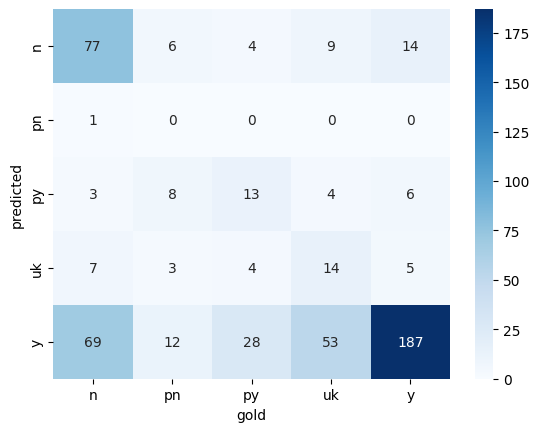

gold        n  pn  py  uk    y
predicted                     
n          77   6   4   9   14
pn          1   0   0   0    0
py          3   8  13   4    6
uk          7   3   4  14    5
y          69  12  28  53  187


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [17]:
pred_results.to_csv('/content/drive/MyDrive/expts_emnlp23/results/A_circa.csv')

In [18]:
df_train['QA'] = df_train['Main_tweet'] + '[SEP]' + df_train['Reply_tweet']
y_train = pd.get_dummies(df_train.gold, prefix='gold')
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_test = pd.get_dummies(df_test.gold, prefix='gold')

In [19]:
# optimizer.learning_rate.assign(0.00002)
model.fit(df_train['QA'], y_train, epochs=200, batch_size=16, callbacks=[callback], validation_data = (df_dev['QA'], y_dev))

Epoch 1/200
208/208 [==============================] - 203s 978ms/step - loss: 1.0097 - accuracy: 0.6051 - precision: 0.7576 - recall: 0.4449 - lr: 3.0000e-05 - val_loss: 1.0521 - val_accuracy: 0.5650 - val_precision: 0.7545 - val_recall: 0.4200 - val_lr: 3.0000e-05
Epoch 2/200
208/208 [==============================] - 199s 955ms/step - loss: 0.7909 - accuracy: 0.7080 - precision: 0.8064 - recall: 0.6018 - lr: 3.0000e-05 - val_loss: 0.9711 - val_accuracy: 0.6233 - val_precision: 0.7338 - val_recall: 0.5283 - val_lr: 3.0000e-05
Epoch 3/200
208/208 [==============================] - 198s 953ms/step - loss: 0.5889 - accuracy: 0.7946 - precision: 0.8519 - recall: 0.7270 - lr: 3.0000e-05 - val_loss: 1.1177 - val_accuracy: 0.6283 - val_precision: 0.6787 - val_recall: 0.5633 - val_lr: 3.0000e-05
Epoch 4/200
208/208 [==============================] - 199s 955ms/step - loss: 0.4138 - accuracy: 0.8582 - precision: 0.8935 - recall: 0.8223 - lr: 3.0000e-05 - val_loss: 1.2823 - val_accuracy: 0.603

In [20]:
print(model.evaluate(df_dev['QA'], y_dev))
y_predicted = model.predict(df_dev['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 13s 710ms/step - loss: 0.9711 - accuracy: 0.6233 - precision: 0.7338 - recall: 0.5283 - lr: 3.0000e-05
[0.9711270332336426, 0.6233333349227905, 0.7337962985038757, 0.528333306312561, 2.9999999242136255e-05]
19/19 [==============================] - 13s 681ms/step
DEV
              precision    recall  f1-score   support

           n       0.62      0.64      0.63       166
          pn       0.50      0.11      0.17        19
          py       0.44      0.46      0.45        61
          uk       0.73      0.47      0.57       113
           y       0.64      0.76      0.70       241

    accuracy                           0.62       600
   macro avg       0.59      0.49      0.50       600
weighted avg       0.63      0.62      0.61       600



In [21]:
print(model.evaluate(df_test['QA'], y_test))
y_predicted = model.predict(df_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 11s 648ms/step - loss: 0.9920 - accuracy: 0.6376 - precision: 0.7275 - recall: 0.5218 - lr: 3.0000e-05
[0.992045521736145, 0.6375711560249329, 0.7275132536888123, 0.5218216180801392, 2.9999999242136255e-05]
17/17 [==============================] - 11s 619ms/step
TEST
              precision    recall  f1-score   support

           n       0.66      0.76      0.71       157
          pn       0.60      0.10      0.18        29
          py       0.44      0.31      0.36        49
          uk       0.53      0.42      0.47        80
           y       0.68      0.78      0.72       212

    accuracy                           0.64       527
   macro avg       0.58      0.47      0.49       527
weighted avg       0.62      0.64      0.62       527



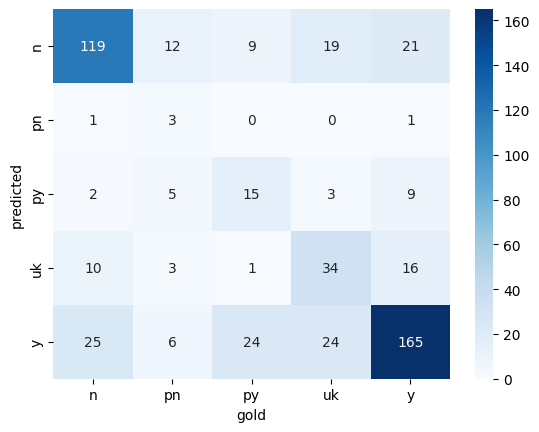

gold         n  pn  py  uk    y
predicted                      
n          119  12   9  19   21
pn           1   3   0   0    1
py           2   5  15   3    9
uk          10   3   1  34   16
y           25   6  24  24  165


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [23]:
pred_results.to_csv('/content/drive/MyDrive/expts_emnlp23/results/A_circa+tuning.csv')